## Selección del modelo 
### Realizado por Víctor Vega Sobral

#### Importación de bibliotecas

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import numpy as np
import joblib


#### Partición del conjunto de datos para test

In [3]:
# Cargar los nuevos datos procesados desde el nuevo csv 
data = pd.read_csv('ple02_gimnasio_procesados.csv')

# La columna o variable objetivo es "Calories_Burned"
X = data.drop('Calories_Burned', axis = 1) # Caracteristicas
y = data['Calories_Burned']


# División del conjunto de datos
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=42)
# Mostrar las dimensiones de los conjuntos resultantes
print(f"Conjunto de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}, {y_test.shape}")


Conjunto de entrenamiento: (504, 5), (504,)
Conjunto de prueba: (217, 5), (217,)


### Selección del modelo
Se probarán 3 modelos diferentes de la librería Scikit-learn: 
- Regresión lineal
- Máquinas de vectores regresores (SVR)
- Regresión de bosque aleatorio 

#### Pasos a seguir
Para los tres modelos, se seguirá el siguiente flujo de trabajo:
1. Creación de instancia del modelo
2. Entrenamiento del modelo 
    1. Validación cruzada.
    2. Exploración de hiperparámetros.
    3. Control de sobreajuste
4. Resultados del entrenamiento.

Una vez realizados estos 4 pasos, se procederá a la **evaluación** de cada uno de los modelos. De esta forma, podremos hacer la evaluación de los 3 a la vez, viendo rápidamente cuál se ha ajustado mejor a nuestro conjunto de datos. 

Para cada uno de los 3 modelos se dará una breve explicación para elegir entre GridSearchCV y RandomizedSearchCV. Se tratan de métodos que usan validación cruzada y exploran los hiperparámetros del modelo, por lo que se podrían hacer en pocas líneas de código los dos primeros pasos del punto número 2 en "pasos a seguir", definidos anteriormente.



### Regresión lineal


In [4]:
# Crear el modelo de regresión lineal
modelo_regresor_lineal = LinearRegression()

# Entrenar el modelo
modelo_regresor_lineal.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = modelo_regresor_lineal.predict(X_test)

ecm = mean_squared_error(y_test, y_pred)
eam = mean_absolute_error(y_test, y_pred)
r2_reg_lineal = r2_score(y_test, y_pred)


print(f"Error Cuadrático Medio: {ecm}")
print(f"Error Absoluto Medio: {eam}")
print(f"R²: {r2_reg_lineal}")

Error Cuadrático Medio: 4093.3050651238923
Error Absoluto Medio: 51.74977617337229
R²: 0.9389799615223673


#### Validación cruzada para la regresión lineal

In [5]:
# Se realiza la validación cruzada
scores = cross_val_score(modelo_regresor_lineal, X, y, cv= 5, scoring='r2')
# Se imprimen los resultados de r^2 para ver si han mejorado

r2_reg_lineal_cruzado = scores.mean()
print(f"Puntuacion del R2: {r2_reg_lineal_cruzado}")

# Hacemos la diferencia entre ambos r2 para encontrar la mejoría del modelo

print(f"El modelo ha mejorado su precisión en {r2_reg_lineal_cruzado - r2_reg_lineal}")


Puntuacion del R2: 0.9432094031599286
El modelo ha mejorado su precisión en 0.0042294416375613375


Se puede observar que, al realizar validación cruzada, el modelo mejora en un  0.004 en r cuadrado.

Aunque se trate de una mejoría pequeña, el modelo ha mejorado su capacidad para explicar la variablilidad de los datos. La validación cruzada ayuda a reducir el riesgo de sobreajuste al evaluar el modelo en varios subconjuntos de los datos, brindando un estimado más estable y confiable del rendimiento real del modelo

### Máquinas de vectores de soporte regresores (SVR)

Se trata de una extensión de las support vector machines (SVM), utilizadas en principio para problemas de clasificación pero ampliadas a problemas de regresión gracias a las SVR.

In [6]:
# Creación de instancia del modelo SVR, ajustando al parámetro rbf

modelo_svr = SVR(kernel = 'rbf') 

# Entrenar el modelo
modelo_svr.fit(X_train, y_train)

# Hacer las predicciones 
y_pred = modelo_svr.predict(X_test)
# Cálculo de las métricas de evaluación

ecm = mean_squared_error(y_test, y_pred)
eam = mean_absolute_error(y_test, y_pred)

r2_svr = r2_score(y_test, y_pred)
# Mostrar las métricas de evaluación
print(f"Error Cuadrático Medio: {ecm}")
print(f"Error Absoluto Medio: {eam}")
print(f"R²: {r2_svr}")


Error Cuadrático Medio: 67161.34825693294
Error Absoluto Medio: 205.81710093568785
R²: -0.0011929210371952603


#### Conclusiones: usar GridSearchCV o RandomizedSearchCV

El r2 negativo significa que el modelo no está funcionando como debería, probablement epor no estar ajustando el hiperparámetro correcto.

Por tanto, usaremos GridSearchCV o RandomizedSeacrhCV, que son capaces de encontrar la mejor elección de hiperparámetros.

En este caso, RandomizedSearch no será tan costoso computacionalmente, por lo que será el que se use.


In [ ]:
# Definir el modelo SVR
modelo_svr_cruzado = SVR()

# Definir la cuadrícula de hiperparámetros
param_dist = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': uniform(0.1, 100),  # Distribución uniforme entre 0.1 y 100
    'gamma': ['scale', 'auto']
}
# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(modelo_svr_cruzado, 
                                   param_distributions=param_dist, 
                                   n_iter=6, 
                                   cv=5, 
                                   scoring='neg_mean_squared_error', 
                                   n_jobs=-1, 
                                   random_state=42)
# Entrenar el modelo con GridSearchCV
random_search.fit(X_train, y_train)

# Obtener el mejor modelo
mejor_modelo_svr = random_search.best_estimator_

# Hacer predicciones en el conjunto de prueba con el mejor modelo
y_pred = mejor_modelo_svr.predict(X_test)

# Calcular las métricas de evaluación
ecm = mean_squared_error(y_test, y_pred)
eam = mean_absolute_error(y_test, y_pred)
r2_svr_cruzado = r2_score(y_test, y_pred)

# Mostrar las métricas de evaluación
print(f"Mejores hiperparámetros: {random_search.best_params_}")
print(f"Error Cuadrático Medio: {ecm}")
print(f"Error Absoluto Medio: {eam}")
print(f"R²: {r2_svr_cruzado}")

print(f"El modelo ha mejorado en {r2_svr_cruzado - r2_svr}")

Mejores hiperparámetros: {'C': 73.2993941811405, 'gamma': 'scale', 'kernel': 'linear'}
Error Cuadrático Medio: 4114.203245320719
Error Absoluto Medio: 51.64096987318156
R²: 0.9386684265306102
El modelo ha mejorado en 0.9398613475678055


### Eventos destacables de la aplicación de validación cruzada

Pese a que RandomizedSearchCV sea un modelo computacionalmente menos costoso que GridSearchCV, sigue teniendo que hacer un número bastante alto de combinaciones de hiperparámetros, con unas iteraciones que se definen en n_iter.

Pese a tener una complejidad computacional mucho menor que GridSearch, sigue dependiendo gravemente del número de pliegues para validación cruzada y el número de iteraciones.

A base de prueba y error, he detectado que a partir de las 5 iteraciones con 5 capas el R cuadrado no aumenta su valor, aumentando únicamente y de forma muy drástica el tiempo de ejecución. 

SVR es un modelo con una complejidad computacional temporal cuadrática (O(N^2)).
La complejidad de randomizedsearch es, aproximadamente: 

$O(\text{n\_iter} \times \text{cv} \times C_{\text{modelo}})$

Siendo C(modelo) la complejidad del modelo a probar. Por tanto, con tan solo cinco iteraciones el modelo presenta una complejidad computacional altísima.

**Aunque no es competencia de la asignatura como tal, la complejidad computacional puede ser un punto decisivo a la hora de elegir el modelo a usar**.




### Creación de función de comparación

Para que sea más fácil la comparacion entre modelos en base a su r2, se va a implementar una función que vaya recibiendo como argumentos un número variable de r2, usando los xargs de Python.


In [8]:
def comparar_r2(*r2_values):
    """
    Compara múltiples valores de R^2 para determinar cuál es el mayor y 
    calcula las diferencias con respecto a los demás.

    Parámetros:
    - *r2_values: Valores de R^2 a comparar. 
    Se pueden proporcionar múltiples valores gracias a usar xargs.

    Retorno:
    - Ninguno (función de comparación).
    Con llamada a función:
        Índice del mejor modelo.
        Diferencia del valor de R^2 frente a los siguientes.
    """
    # Encontrar el R^2 máximo y su índice
    mejor_r2 = max(r2_values)
    mejor_modelo_index = r2_values.index(mejor_r2) + 1  

    # Calcular las diferencias con respecto al mejor R^2
    diferencias = [mejor_r2 - r2 for r2 in r2_values if r2 != mejor_r2]

    # Mostrar resultados
    print(f"El modelo con el mayor R^2 es el Modelo {mejor_modelo_index} con un valor de {mejor_r2:.4f}.")
    if diferencias:
        print(f"La diferencia con los otros modelos es: {[f'{d:.4f}' for d in diferencias]}")

# Comparación entre el modelo de regresión lineal y SVR
comparar_r2(r2_reg_lineal_cruzado, r2_svr_cruzado)  

El modelo con el mayor R^2 es el Modelo 1 con un valor de 0.9432.
La diferencia con los otros modelos es: ['0.0045']


#### Resultados de la prueba
De todas formas, al aplicar validación cruzada, se han solventado exitosamnete los problemas del SVR, pasando de un r cuadrado negativo a uno muy cercano al del modelo anterior, con tan solo 0.0014 menos.

Se trata de un valor muy positivo si se parte del valor inicial del SVR. No obstante, presenta dos grandes desventajas frente al modelo de regresión lineal:
1. **Valor de r2 menor**: pese a ser poca la diferencia, el modelo de regresión lineal sigue siendo menor.

2. **Costo computacional muy elevado**: se trata de un modelo con una complejidad computacional mucho más alta. No solo en el propio modelo en si (O(p) frente a O(n^2)), sino también por el costo añadido de usar RandomizedSearchCV, que vuelve el tiempo de ejecución muy elevado. 

Por tanto, de momento, el mejor modelo sigue siendo el de regresión lineal

### Random forest

Se trata de un algoritmo que se basa en la idea de construir un conjunto de árboles de decisión y combinar sus resultados para mejorar la precisión y controlar el sobreajuste.

In [9]:
from sklearn.ensemble import RandomForestRegressor
# Crear el modelo RandomForestRegressor
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo
modelo_rf.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = modelo_rf.predict(X_test)

# Calcular las métricas de evaluación
ecm = mean_squared_error(y_test, y_pred)
eam = mean_absolute_error(y_test, y_pred)
r2_forest = r2_score(y_test, y_pred)

# Mostrar las métricas de evaluación
print(f"Error Cuadrático Medio: {ecm}")
print(f"Error Absoluto Medio: {eam}")
print(f"R²: {r2_forest}")

Error Cuadrático Medio: 4118.92731889401
Error Absoluto Medio: 52.085806451612896
R²: 0.9385980034503298


### Validación cruzada para RandomForest

Volvemos a usar la función cross_val_score.
Posteriormente, se usará la función **comparar_r2()** para ver finalmente las diferencias entre los 3 modelos

In [10]:
# Crear el modelo RandomForestRegressor
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Realizar la validación cruzada
scores = cross_val_score(modelo_rf, X, y, cv=5, scoring='r2')

# Calcular la puntuación promedio de R² en la validación cruzada
r2_forest_cruzado = scores.mean()
print(f"Puntuación del R² en validación cruzada: {r2_forest_cruzado}")

comparar_r2(r2_reg_lineal_cruzado, r2_svr_cruzado, r2_forest_cruzado)

Puntuación del R² en validación cruzada: 0.9430592915911001
El modelo con el mayor R^2 es el Modelo 1 con un valor de 0.9432.
La diferencia con los otros modelos es: ['0.0045', '0.0002']


## Conclusiones

Una vez realizados los 3 modelos, se pueden extraer las siguientes conclusiones: 

#### Mejor métrica de evaluación: R^2
Pese a usar también el error cuadrático medio y absoluto, la métrica usada para comparar los 3 modelos ha sido finalmente el **$R^2$**. Existen 3 principales razones para usar esta métrica:

1. **Interpretación**: $R^2$ proporciona una medida fácil de interpretar, puesto que cuanto más alto sea, mejor explica el modelo los datos. Esto facilita la comparación entre modelos, ya que todos están normalizados en el mismo rango de 0 a 1. 

2. **Escala y simplicidad**: Se trata de una interpretación mucho más sencilla de ver a simple vista si no se tiene mucho conocimiento de la medida de las unidades que se está usando en el conjunto de datos. En el error cuadrático medio y absoluto, se deben conocer las unidades de medidas (en este caso de calorías) y evaluar este resultado sabiendo la escala del problema y qué tan asumible es ese error. 

Es decir, se tiene que saber el rango de los datos, por ejemplo entre 0 y 1000, y luego evaluar cuán aceptable es el error. Sin embargo, $R^2$ no posee unidades, por lo que es mucho más fácil de interpretar a simple vista si el modelo ha mejorado o empeorado.

Un valor cercano a 0 sugiere que no funciona bien, mientras que cercano a 1 captura bien la relación entre las variables.

3. **Contexto de mejora**: en el caso de tener $R^2$ negativos, rápidamente se sabe que el modelo se desempeña peor que simplemente prediciendo la media de la variable de respuesta. 

Finalmente, el error cuadrático medio y absoluto son dos métricas más difíciles de interpretar a la hora de decidir qué modelo es mejor. Si un modelo tiene un ECM menor, pero otro un $R^2$ más alto, el $R^2$ puede proporcional una mejor visión del desempeño general del modelo.


#### Mejor modelo: Regresión lineal.

El modelo de regresión lineal ha sido finalmente el que mejor desempeño ha tenido, principalmente por tres razones.

- Es el modelo con una menor **complejidad computacional**. Es un modelo que tarda mucho menos en ejecutarse que SVR y RandomForest, con una diferencia aproximada de 3 segundos, valor que sería mucho más alto si se hiciese un mayor número de iteraciones. Se trata de un punto a tener en cuenta a la hora de desplegar un modelo, sobretodo si el conjunto de datos va a ser más grande.

- **Modelo más simple**: se trata del modelo con la idea más simple. A la hora de explicar el modelo a otra persona que no tenga conocimientos, explicar la regresión lineal es mucho más facil que SVR o RandomForest, puesto que sólo se debe explicar que predice valores de una variable respecto a otras que dependen de ella. 

- **Mejor $R^2$**: es el modelo con un mejor $R^2$, aunque las diferencias sean muy pequeñas. Además, si se compara el desempeño de los modelos sin aplicar validación cruzada, se trata de una opción mucho más robusta que SVR, dado que este tenía en principio un $R^2$ negativo.




## Siguientes pasos

Los pasos siguientes serían los relacionados al despliegue del modelo. Para ello, se debe realizar un archivo de pesos del modelo, que permitan que no se deba ejecutar todo el código todas las veces que se quiera usar el modelo.

Finalmente, se podría considerar volver al EDA para probar la eliminación o adición de columnas en el conjunto de datos, con el objetivo de intentar maximizar el valor de R^2.

No obstante, el valor de por sí es elevado, por lo que debe valorar la opción de tener un modelo con unas variables intuitivamente menos representativas pero con un ligero mejor desempeño, o por el contrario quedarse con un modelo con un valor de precisión acertado, algo menor, pero con unas variables mucho más intuitivas a la hora de explicar en base a qué variables se ha entrenado el modelo.

La decisión queda a gusto del usuario final. 

#### Persistencia del modelo
Se usará **joblib**, una opción recomendada para guardar modelos de Scikit-learn, que además es más eficiente que otras opciones como pickle en términos de espacio y velocidad en objetos grandes, como modelos de aprendizaje automático.

Además, se trata de una opción más simple a la hora de implementarlo en Python. 

También se crearán **4 nuevos csv**, cada uno perteneciente a las 4 variables del conjunto de datos de entrenamiento y test, para tener un registro de fiable de con qué datos se ha entrenado y evaluado el modelo. Se trata de un paso útil que evita que haya fallos posteriormente si los datos cambian.

In [ ]:
# Crear el modelo de regresión lineal
modelo_regresor_lineal = LinearRegression()

# Realizar la validación cruzada
scores = cross_val_score(modelo_regresor_lineal, X, y, cv=5, scoring='r2')
r2_reg_lineal_cruzado = scores.mean()
print(f"Puntuacion del R2: {r2_reg_lineal_cruzado}")

# Entrenar el modelo con todos los datos
modelo_regresor_lineal.fit(X, y)

# Guardar el modelo entrenado
joblib.dump(modelo_regresor_lineal, 'modelo_regresion_lineal.pkl')

# Guardar los conjuntos de datos en archivos CSV
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)



Puntuacion del R2: 0.9432094031599286


#### Carga del modelo para comprobar que ha sido exportado correctamente

Para comprobar que funciona correctamente, deberíamos poseer otro conjunto de datos.

Esto se debe a que nuestro conjunto de datos actual es con el que se acaba de entrenar el modelo. Por tanto, es probable que al cargarlo de nuevo sobre este, el $R^2$ aumente debido a que ya ha visto anteriormente todos estos datos. 

Por tanto, se recomienda poseer otro dataset del estilo o nuevos datos para comprobar que el modelo está funcionando correctamente. No obstante, para comprobar que el archivo se ha creado exitosamente y que funciona, se trata de una opción rápida y útil para su propósito.

In [12]:
# Cargar el modelo guardado
modelo_cargado = joblib.load('modelo_regresion_lineal.pkl')
# Verificar que el modelo cargado funciona correctamente
y_pred_cargado = modelo_cargado.predict(X)

r2_cargado = modelo_cargado.score(X, y)

print(f"R² del modelo cargado: {r2_cargado}")

R² del modelo cargado: 0.9440224555762704


## Comprobaciones a mayores

Debido a que el error cuadrático medio de todos los modelo tiene valores muy altos, es más que probable que algunas de las predicciones que hacen los modelos tengan unos valores muy alejados de la etiqueta objetivo que deberían tener.

Por tanto, es recomendable **visualizar estas predicciones** y una vez visto el origen de esta métrica, tomar decisiones sobre qué hacer con el modelo. Las dos principales opciones son:

1. **Eliminar las predicciones atípicas**: una vez visualizadas estas predicciones, proceder a su eliminación y evaluar de nuevo el modelo. Si el error cuadrático medio disminuye, mientras se mantienen el $R^2$ y el error absoluto iguales o aumentando, será recomendable eliminar dichas predicciones.


2. **Permanecer con el modelo actual**: una vez visualizados estas predicciones atípicas, se mantiene el mismo modelo sin eliminarlas debido a que no se alcanza una mejora significativa en ninguna de las métricas del modelo.

Dichas comprobaciones se harán primero en el modelo elegido, es decir, en el regresor lineal. Si se da el primer caso, se procederá también a comprobar los otros dos modelos. Si por el contrario no mejora, se mantendrá solo esta evaluación en el regresor lineal.

Esto se debe principalmente a que tenemos otras dos métricas con unos valores bastante altos y positivos, por lo que, una vez comprendido el valor del error cuadrático medio y experimentado para disminuirlo, tampoco es necesario proceder al cambio del modelo al tener otras dos métricas positivas y más robustas a los errores puntuales de algunas de las predicciones.

A modo de aclaración, una predicción atípica es aquella donde la diferencia entre el valor real y el valor predicho (residuo) es mucho mayor que la mayoría de las diferencias observadas


#### Visualización de las predicciones atípicas.


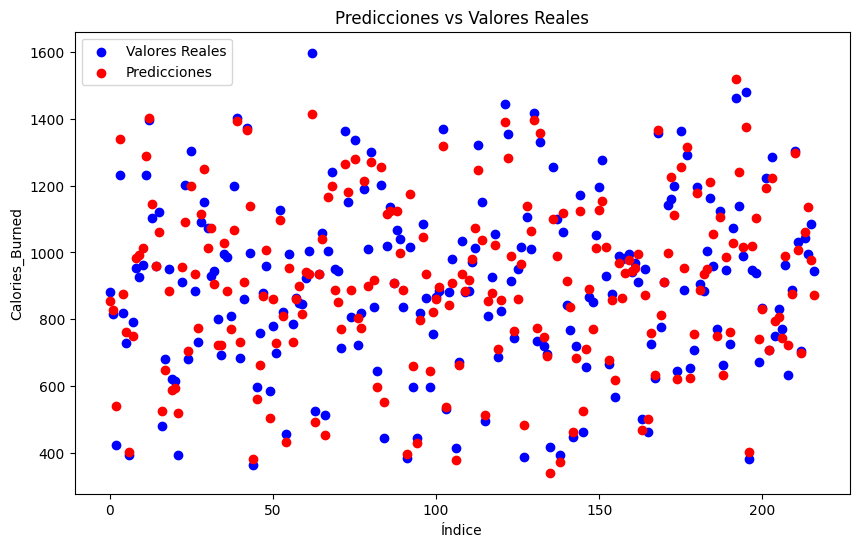

In [13]:
# Cargar los datos de prueba
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv').values.flatten()

# Realizar predicciones con el modelo cargado
y_pred = modelo_cargado.predict(X_test)

# Visualizar las predicciones en un gráfico
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Valores Reales')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Calories_Burned')
plt.legend()
plt.show()





#### Identificación de predicciones atípicas

In [ ]:
residuals = np.abs(y_test - y_pred)
threshold = np.mean(residuals) + 2 * np.std(residuals)
outliers = residuals > threshold

#### Visualizar las predicciones atípicas en un gráfico

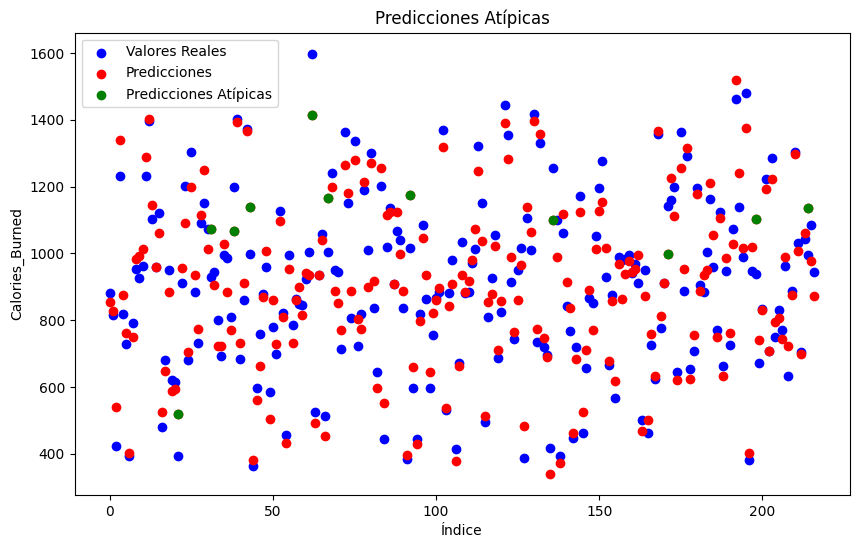

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Valores Reales')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicciones')
plt.scatter(np.where(outliers)[0], y_pred[outliers], color='green', label='Predicciones Atípicas')
plt.title('Predicciones Atípicas')
plt.xlabel('Índice')
plt.ylabel('Calories_Burned')
plt.legend()
plt.show()

A simple vista, se puede destacar que no hay un número elevado de predicciones atípicas en comparación con el número de predicciones totales

#### Mostrar el número de predicciones atípicas y sus valores reales frente a los predichos

In [24]:
print(f"Número de predicciones atípicas: {np.sum(outliers)}")
print("Valores reales vs Predicciones atípicas:")
for real, pred in zip(y_test[outliers], y_pred[outliers]):
    print(f"Real: {real},  Predicho: {pred}\n")

Número de predicciones atípicas: 11
Valores reales vs Predicciones atípicas:
Real: 394.0,  Predicho: 520.6340967229575

Real: 929.0,  Predicho: 1071.8402584917785

Real: 1198.0,  Predicho: 1067.4308062871455

Real: 999.0,  Predicho: 1139.4672603109143

Real: 1598.0,  Predicho: 1415.099379063824

Real: 1005.0,  Predicho: 1167.5230094782496

Real: 1016.0,  Predicho: 1176.109369239793

Real: 1257.0,  Predicho: 1098.7675910890953

Real: 1143.0,  Predicho: 997.3764706563824

Real: 940.0,  Predicho: 1102.8257393023082

Real: 996.0,  Predicho: 1137.0608395246295

Media de la diferencia entre el valor real y el valor predicho en las predicciones atípicas: 150.3442114521985


In [33]:
# Calcular la media de la diferencia entre el valor real y el valor predicho en las predicciones atípicas
mean_difference_outliers = np.mean(residuals[outliers])

mensaje_diferencia = f"""
Media de diferencia entre valor real y valor predicho en predicciones atípicas: \n
{mean_difference_outliers}

"""
print(mensaje_diferencia)


Media de diferencia entre valor real y valor predicho en predicciones atípicas: 

150.3442114521985


Predicción atípica con la mayor diferencia:
182.90062093617598


In [34]:
# Encontrar la predicción atípica con la mayor diferencia entre el valor real y el valor predicho
max_difference_index = np.argmax(residuals[outliers])
max_difference_real = y_test[outliers][max_difference_index]
max_difference_pred = y_pred[outliers][max_difference_index]

print(f"Predicción atípica con la mayor diferencia:")
print(f"{max_difference_real - max_difference_pred}")

Predicción atípica con la mayor diferencia:
182.90062093617598


Como se puede observar, el modelo tan solo tiene 11 predicciones atípicas, lo que corrobora lo comentado del gráfico. Además, estas predicciones, aun teniendo un error considerable conociendo el rango y valor de las calorías quemadas en un entrenamiento, tampoco son excesivamente elevadas como se podría pensar en un primer momento. 

De hecho, la media entre el valor real y el valor predicho en estas predicciones es de 150 calorías, número elevado pero no desorbitado. De hecho, la peor predicción tiene una diferencia entre el valor real y el valor predicho de 182.9 calorías.

En este momento, si hubiese un mayor número de predicciones atípicas o las demás métricas del modelo presentasen datos no tan positivos, se podría entrar a considerar si es aceptable que existan predicciones con este error, teniendo en cuenta el contexto del conjunto de datos y del problema en un entorno real.

#### Re-entrenar el regresor lineal sin predicciones atípicas

In [21]:
# Cargar los datos de entrenamiento
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv').values.flatten()

# Entrenar el modelo de regresión lineal con los datos originales
modelo_regresor_lineal = LinearRegression()
modelo_regresor_lineal.fit(X_train, y_train)

# Realizar predicciones con los datos de entrenamiento
y_train_pred = modelo_regresor_lineal.predict(X_train)

# Identificar predicciones atípicas en los datos de entrenamiento
residuals_train = np.abs(y_train - y_train_pred)
threshold_train = np.mean(residuals_train) + 2 * np.std(residuals_train)
outliers_train = residuals_train > threshold_train


# Eliminar las predicciones atípicas de los datos de entrenamiento
X_train_cleaned = X_train[~outliers_train]
y_train_cleaned = y_train[~outliers_train]

# Volver a entrenar el modelo de regresión lineal con los datos limpios
modelo_regresor_lineal_cleaned = LinearRegression()
modelo_regresor_lineal_cleaned.fit(X_train_cleaned, y_train_cleaned)

# Evaluar el modelo con los datos de prueba
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv').values.flatten()
y_pred_cleaned = modelo_regresor_lineal_cleaned.predict(X_test)
mse_cleaned = mean_squared_error(y_test, y_pred_cleaned)
print(f"Error cuadrático medio después de eliminar predicciones atípicas: {mse_cleaned}")


Error cuadrático medio después de eliminar predicciones atípicas: 4152.606453865106


## Conclusiones

Después de realizar el análisis de las predicciones atípicas, se pueden extraer las siguientes conclusiones:

1. El modelo no tiene un número muy elevado de predicciones atípicas, contando únicamente con 11 predicciones con un error más alto. Dichas predicciones tienen una diferencia entre el valor real y predicho de 150 calorías, siendo la más elevada de 182.9. Es decir, **el modelo tiene pocas predicciones atípicas y con un error alto pero no desorbitado**.

2. Tras el reentrenamiento del modelo después de la eliminación de las predicciones atípicas, no solo no mejora, si no que **el error cuadrático medio aumenta**, por lo que se **mantiene el modelo con el conjunto de entrenamiento y test anterior**.

3. Dado que el modelo presenta unas métricas de error absoluto medio y de $R^2$ bastante positivas y tan solo hay 11 predicciones atípicas, se confirma, con un caso real, que **el error cuadrático medio** es una métrica muy condicionada a las predicciones atípicas. Por tanto, para el caso de este modelo y después de haber realizado las comprobaciones correspondientes, es probable que el error cuadrático medio **no sea la mejor métrica para evaluar el correcto rendimiento del modelo**. 

Por tanto, la conclusión final es que **se mantiene el regresor lineal elegido**, trashaber comprobado que el número de predicciones atípicas no es muy elevado y se tiene un $R^2$ alto y un error medio absoluto bastante bajo.